In [3]:
%env CUDA_VISIBLE_DEVICES= 1


import os
os.environ['HF_HOME'] = '/home/sofia/cache_custom'
## IndicTrans2
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
# from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm
from torch.nn.functional import softmax
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


BATCH_SIZE = 4 # edited from 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
print(DEVICE)
# print(torch.cuda.get_device_name())
import transformers
print(transformers.__version__)
import importlib
import possible_indic_relations as poss_indic_rel
import span_encodings as sp_enc
# Reload the module to reflect changes
importlib.reload(poss_indic_rel)
importlib.reload(sp_enc)
import pandas as pd
pir= poss_indic_rel.possible_relations
print(pir)

ambiguos_words = list(pir.keys())
span_encodings = sp_enc.span_encodings
# drop "child" item from ambiguos_words
index_child = ambiguos_words.index("child")
ambiguos_words.pop(index_child)

print(ambiguos_words)

env: CUDA_VISIBLE_DEVICES=1
cuda
4.48.1
{'grandmother': {'ory_Orya': {'ଜେଜେମା': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'ଆଈ': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}}, 'ben_Beng': {'ঠাকুরমা': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'দিদি মা': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}}, 'guj_Gujr': {'દાદી': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'નાની': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}}, 'hin_Deva': {'दादी': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'नानी': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}, 'पितामही': {'description': 'father

In [4]:
lang_script_list = [
    'hin_Deva', 
    'guj_Gujr',
    'mar_Deva', 
    'ory_Orya',
     'ben_Beng', 
    'tam_Taml', 
    'pan_Guru',
     'tel_Telu',
      'mal_Mlym', 'kan_Knda', 
                           ]
lang_code_map = {
    'eng_Latn': 'Eng',
    'hin_Deva': 'Hin',
    'guj_Gujr': 'Guj',
    'kan_Knda': 'Kan',
    'mal_Mlym': 'Mal',
    'mar_Deva': 'Mar',
    'tam_Taml': 'Tam',
    'tel_Telu': 'Tel',
    'pan_Guru': 'Pun',
    'ben_Beng': 'Ben',
    'ory_Orya': 'Odi'
}

# SAMPLE_SIZE = len(sents)


# pick up random samples
# SAMPLE_SIZE = 60
# import random
# random.seed(42)
# sents = random.sample(sents, SAMPLE_SIZE)

# sents
SAMPLE_SIZE = 10557

In [7]:
test_diff_confn_mat= [[-0.9563671946525574, -0.9959551692008972, 0, -0.9997027516365051, 0.03829708695411682, 0.3729094862937927, -0.9341439008712769, 0.943178653717041, 0, 0], [-0.9727887511253357, 0.38336774706840515, 0, -0.9990313053131104, -0.02056330442428589, 0, -0.9929695725440979, 0, 0, 0], [-0.8003621101379395, 0.04723989963531494, -0.05213668942451477, 0.9892522692680359, 0.07669368386268616, -0.4483254551887512, -0.28975793719291687, 0.013987064361572266, 0.352111279964447, -0.993064284324646], [-0.8688442707061768, -0.970579981803894, 0.34336230158805847, 0.9799522161483765, -0.21196061372756958, -0.7263556718826294, 0.9880340099334717, -1.0, 0.07172101736068726, 0], [0.8648267388343811, 0.46762534976005554, 0.7739558219909668, 0.9960252642631531, 0.8229594826698303, 0.572455883026123, 0.5871224403381348, 1.0000001192092896, 1.0000001192092896, 0.06499302387237549], [0.5882759094238281, -0.05484640598297119, 0.6899681687355042, -0.7323548793792725, -0.24532288312911987, -0.44466152787208557, -0.7917875647544861, -1.0, -0.7088733315467834, -0.998361349105835], [-0.9974820017814636, 0.24629539251327515, -0.12733688950538635, -0.9995854496955872, 0.03204476833343506, -0.18152427673339844, 0.09288895130157471, -0.5206584930419922, 0, -0.14147266745567322], [-0.11707887053489685, 0.3341433107852936, -0.12576866149902344, -0.18320399522781372, -0.3904668390750885, -0.43326711654663086, 0.07009467482566833, -0.23288476467132568, -0.9184145331382751, -0.0086517333984375], [-0.9049844741821289, 0.3350444734096527, 0.9093130826950073, 0.905259370803833, -0.15766429901123047, -0.5405644774436951, -0.5162186622619629, -0.9992238879203796, -0.1828736960887909, -0.1433224081993103]]


In [46]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1

def plot_confusion_mat(confusion_mat, ambiguos_words, lang_code_map, annot, filename, cmap_name, legend_title ):
    fig, ax = plt.subplots(figsize=(9,7), dpi= 200)
    # cmap = plt.cm.bwr  # Base colormap: Blue-White-Red # TODO: change for ratio
    cmap= cmap_name
    cmap.set_bad(color='black')  # Map NaN values to black
    # give colour custommed as max value as Pink and min value as blue and 0 as white
    cax = ax.matshow(confusion_mat, cmap=cmap)
    # fig.colorbar(cax)
    # Create the plot
    # cax = ax.matshow(confusion_mat, cmap=cmap,)# norm=Normalize(vmin=-1, vmax=1))

    if annot:
        # Annotate values in the matrix
        # rows, cols = confusion_mat.shape
        rows = len(confusion_mat)
        cols = len(confusion_mat[0])
        for i in range(rows):
            for j in range(cols):
                value = confusion_mat[i][j]
                if not np.isnan(value):  # Skip NaN values
                    ax.text(j, i, f'{value:.2f}'.lstrip('0'), ha='center', va='center', fontsize=15, color = 'black')


    # Add colorbar
    cbar = fig.colorbar(cax)
   
    # Customize colorbar tick labels
    cbar.set_ticks([-1, 0, 1])  # Set ticks at min, mid, and max # TODO change the min, max values; make dynamic
    # cbar.set_ticklabels(["Patriarchy", "Neutral", "Matriarchy"]) 
    cbar.ax.text(0.9, -0.03, "Patriarchy", ha="center", va="center", fontsize=15,   transform=cbar.ax.transAxes, )
    cbar.ax.text(0.9, 1.025, "Matriarchy", ha="center", va="center", fontsize=15,   transform=cbar.ax.transAxes, )
    cbar.ax.tick_params(labelsize=15)
    

     
    
    # # ax.set_xticks(range(len(final_res.keys()))) 
    # ax.set_xticks(range(len(lang_script_list)))
    # # ax.set_xticklabels( list(lang_code_map[lang] for lang in final_res.keys()),  ha="center")
    # ax.set_xticklabels( list(lang_code_map[lang] for lang in lang_script_list),  ha="center", fontsize=13, )
    # # ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))
    # ax.set_yticklabels(['']+ambiguos_words, fontsize=13)
    # #  Position the x-axis labels (ticks and labels) below the plot
    # # ax.xaxis.set_label_position('bottom')  # Position the label below
    # Move x-axis labels to the bottom
    ax.set_xticks(range(len(lang_script_list)))
    ax.set_xticklabels([lang_code_map[lang] for lang in lang_script_list], ha="center", fontsize=15)
    ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to bottom
    ax.xaxis.set_label_position('bottom')  # Move x-axis label to bottom

    ax.set_yticklabels([''] + ambiguos_words, fontsize=15)
   
    # ax.set_xtick_position('bottom') 
    plt.xlabel('Languages', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.title(legend_title, fontsize=15, pad=10, loc='right')
    # save the image to a file
    # Add a small black box legend below the plot
    # black_patch = mpatches.Patch(color='black', label='Language exhibits single-gender bias.')
    # plt.legend(handles=[black_patch], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=10, frameon=False)
    fig.tight_layout()
    fig.savefig('../results/logits_/'+filename+  ('num' if annot else '') + '.png')
    plt.show()



/tmp/ipykernel_635512/1652602798.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ambiguos_words, fontsize=15)


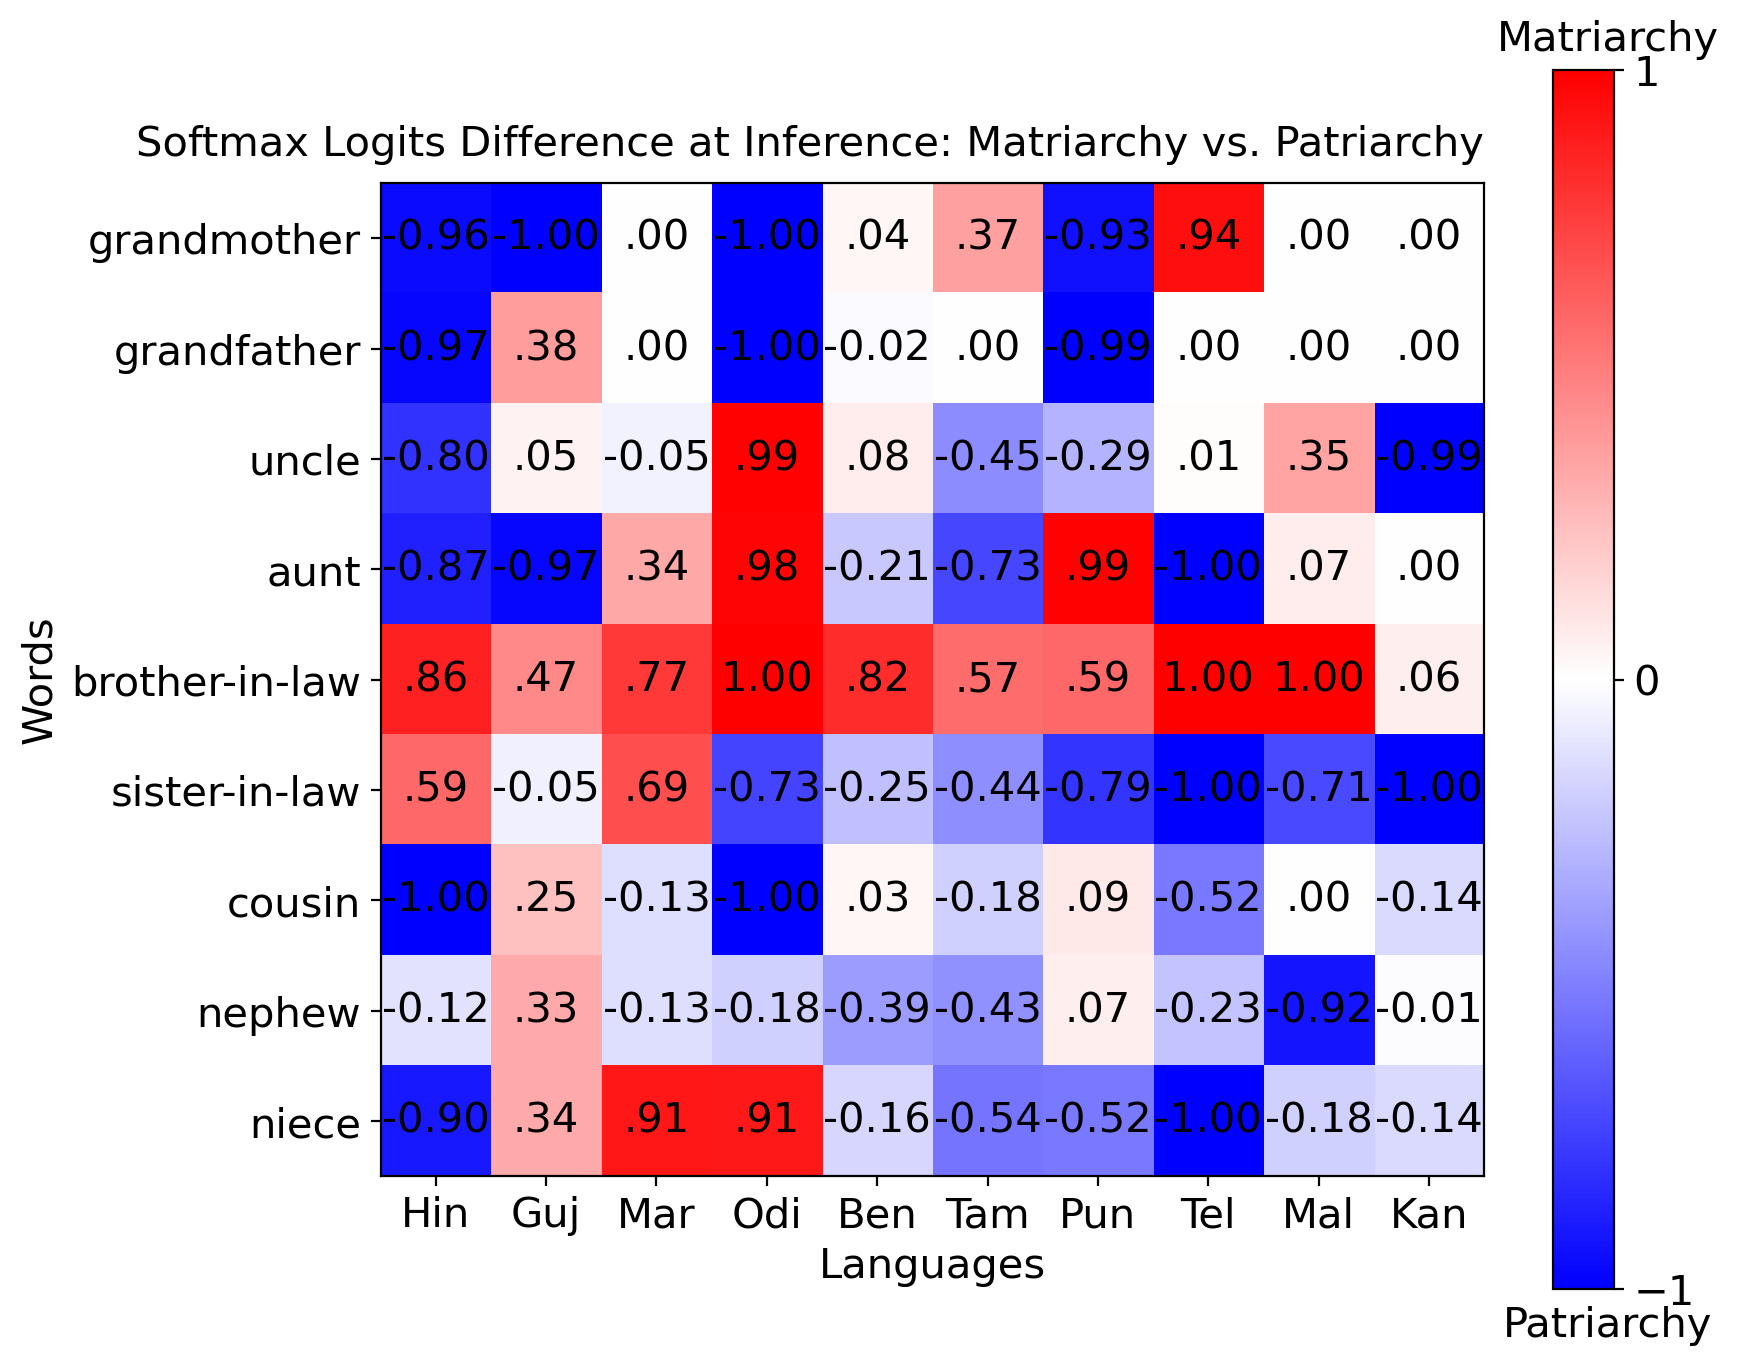

/tmp/ipykernel_635512/1652602798.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ambiguos_words, fontsize=15)


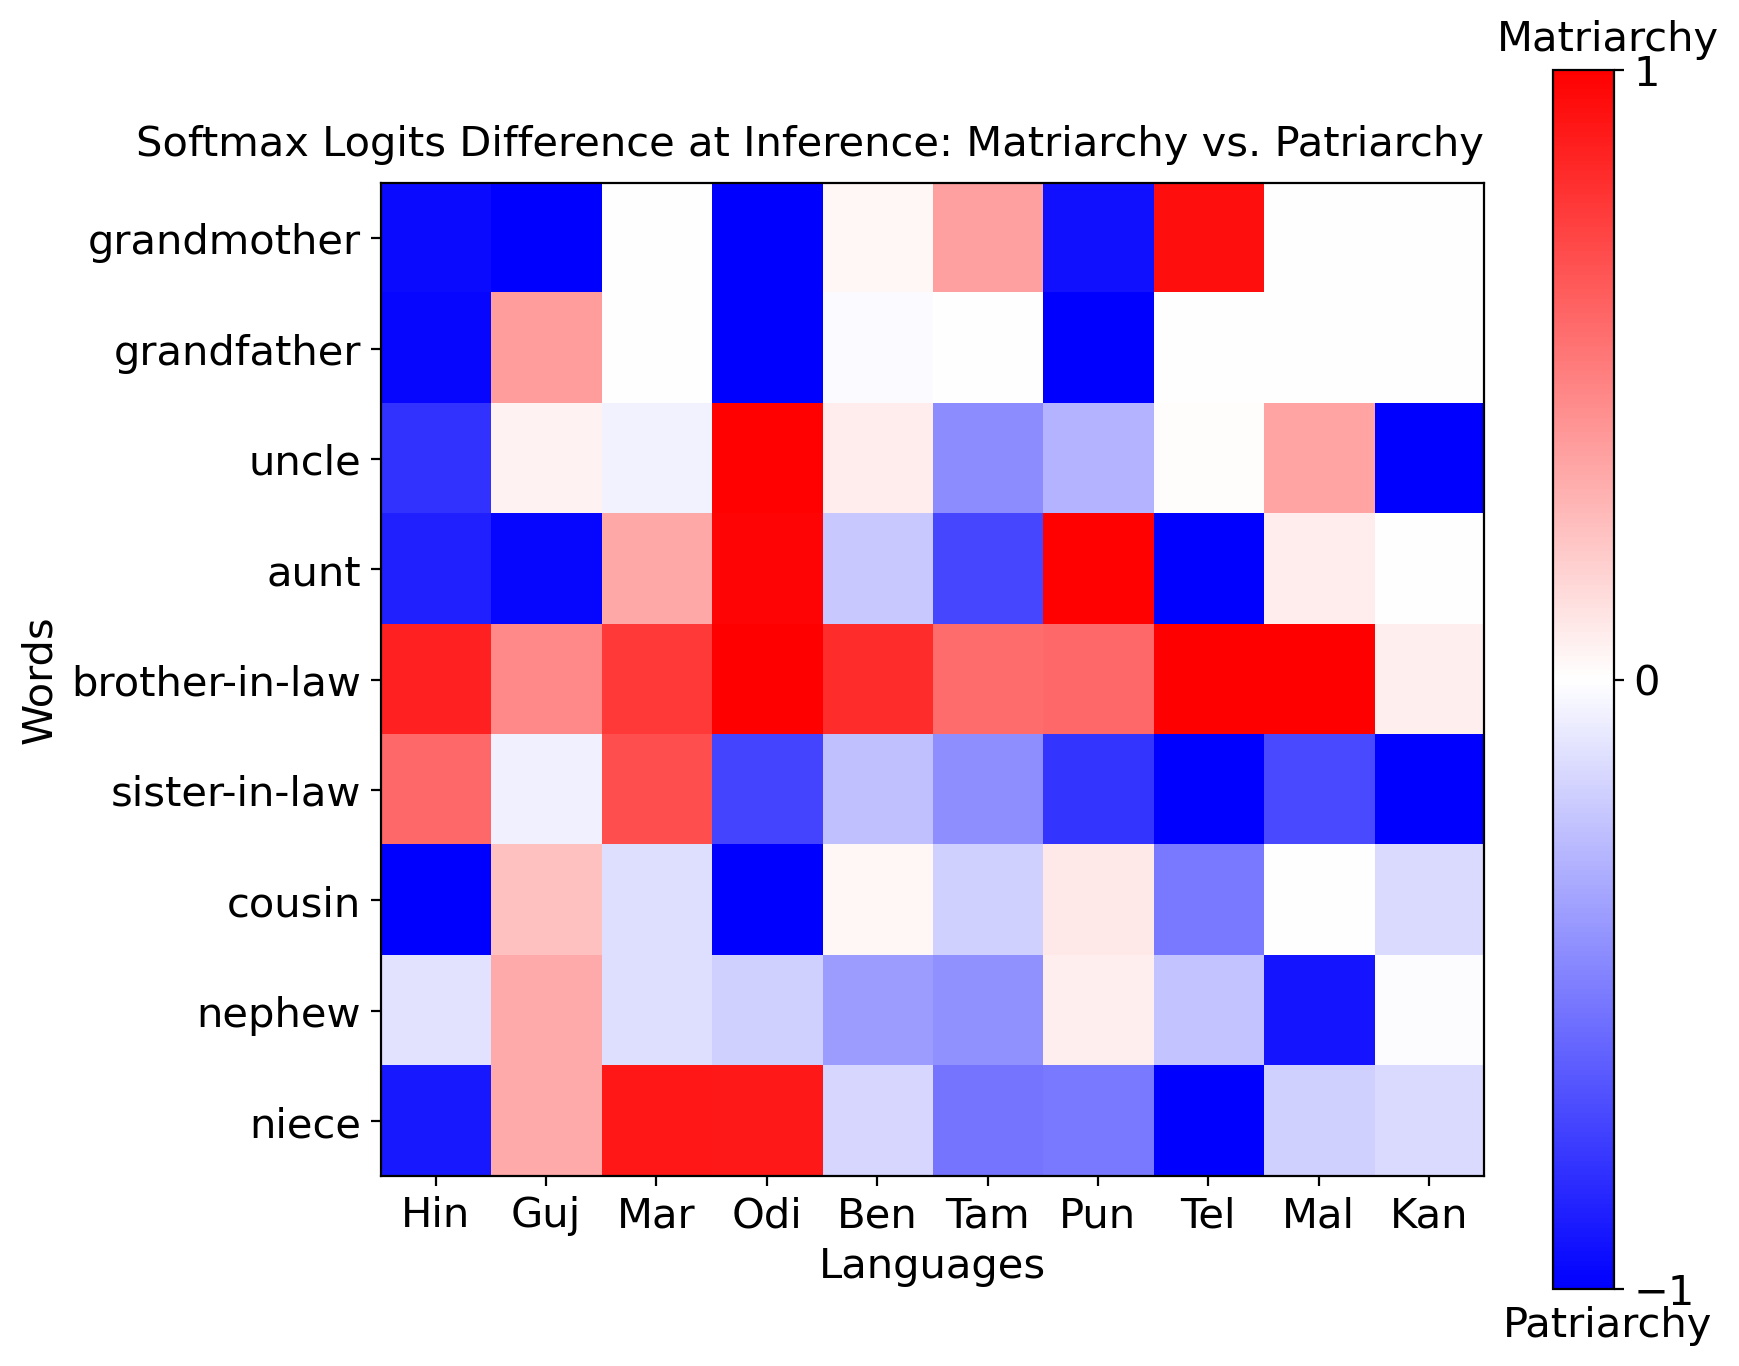

In [47]:

plot_confusion_mat(test_diff_confn_mat,  ambiguos_words, lang_code_map, annot=True, filename='logit_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Softmax Logits Difference at Inference: Matriarchy vs. Patriarchy')
plot_confusion_mat(test_diff_confn_mat,  ambiguos_words, lang_code_map, annot=False, filename='logit_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Softmax Logits Difference at Inference: Matriarchy vs. Patriarchy')
# plot_confusion_mat(confusion_mat_ratio,  ambiguos_words, lang_code_map, annot=True, filename='logit_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Inference')
# plot_confusion_mat(confusion_mat_ratio,  ambiguos_words, lang_code_map, annot=False, filename='logit_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Inference')

## Train Set details

In [48]:
trainset_counts={
    'tam_Taml': {'uncle': {'Matriarch': 1107, 'Patriarch': 11}, 'aunt': {'B': 207, 'Matriarch': 24}, 'grandfather': {'B': 1234}, 'grandmother': {'B': 294}, 'brother-in-law': {'Matriarch': 34}, 'nephew': {'Matriarch': 1, 'Patriarch': 4}, 'niece': {'Matriarch': 2, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 10, 'Patriarch': 13}, 'cousin': {'Matriarch': 8, 'Patriarch': 43}}
,
'mar_Deva': {'uncle': {'Matriarch': 160, 'Patriarch': 265}, 'aunt': {'Matriarch': 48, 'Patriarch': 74}, 'grandfather': {'B': 966}, 'grandmother': {'B': 392}, 'brother-in-law': {'Matriarch': 47, 'Patriarch': 10}, 'nephew': {'Matriarch': 72, 'Patriarch': 2}, 'niece': {'Matriarch': 70, 'Patriarch': 33}, 'sister-in-law': {'Matriarch': 23, 'Patriarch': 24}, 'cousin': {'Matriarch': 6, 'Patriarch': 135}}
,
'ory_Orya': {'uncle': {'Matriarch': 95, 'Patriarch': 23}, 'aunt': {'Matriarch': 9, 'Patriarch': 4}, 'grandfather': {'Matriarch': 28, 'Patriarch': 129}, 'grandmother': {'Matriarch': 6, 'Patriarch': 107}, 'brother-in-law': {'Matriarch': 7, 'Patriarch': 2}, 'nephew': {'Matriarch': 14, 'Patriarch': 32}, 'niece': {'Matriarch': 9, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 7, 'Patriarch': 17}, 'cousin': {'Patriarch': 59}}
,
'hin_Deva': {'uncle': {'Matriarch': 619, 'Patriarch': 1894}, 'aunt': {'Matriarch': 241, 'Patriarch': 380}, 'grandfather': {'Matriarch': 169, 'Patriarch': 1702}, 'grandmother': {'Matriarch': 152, 'Patriarch': 1633}, 'brother-in-law': {'Matriarch': 341, 'Patriarch': 129}, 'nephew': {'Matriarch': 53, 'Patriarch': 291}, 'niece': {'Matriarch': 218, 'Patriarch': 627}, 'sister-in-law': {'Matriarch': 87, 'Patriarch': 410}, 'cousin': {'Matriarch': 614, 'Patriarch': 1698}}
,
'kan_Knda': {'uncle': {'Matriarch': 4, 'Patriarch': 896}, 'aunt': {'B': 367}, 'grandfather': {'B': 1188}, 'grandmother': {'B': 1552}, 'brother-in-law': {'Matriarch': 67, 'Patriarch': 12}, 'nephew': {'Patriarch': 4}, 'sister-in-law': {'Patriarch': 60}, 'cousin': {'Matriarch': 23, 'Patriarch': 29}}
,
'pan_Guru': {'uncle': {'Matriarch': 22, 'Patriarch': 124}, 'aunt': {'Matriarch': 55, 'Patriarch': 19}, 'grandfather': {'Matriarch': 25, 'Patriarch': 374}, 'grandmother': {'Matriarch': 103, 'Patriarch': 294}, 'brother-in-law': {'Matriarch': 44}, 'nephew': {'Patriarch': 54}, 'niece': {'Patriarch': 75}, 'sister-in-law': {'Matriarch': 4, 'Patriarch': 11}, 'cousin': {'Matriarch': 111, 'Patriarch': 15}}
,
'tel_Telu': {'uncle': {'Matriarch': 281}, 'aunt': {'B': 9, 'Patriarch': 303}, 'grandfather': {'B': 42}, 'grandmother': {'Matriarch': 553, 'Patriarch': 2}, 'brother-in-law': {'B': 1, 'Matriarch': 39}, 'nephew': {'Matriarch': 6}, 'niece': {'Matriarch': 3, 'Patriarch': 113}, 'sister-in-law': {'Patriarch': 11}, 'cousin': {'Patriarch': 23}}
,
'mal_Mlym': {'uncle': {'B': 519, 'Matriarch': 13}, 'aunt': {'Matriarch': 9}, 'grandfather': {'B': 64}, 'grandmother': {'B': 290}, 'brother-in-law': {'B': 1, 'Matriarch': 2}, 'nephew': {'Matriarch': 27, 'Patriarch': 46}, 'niece': {'Matriarch': 12, 'Patriarch': 11}, 'sister-in-law': {'B': 2, 'Matriarch': 5}, 'cousin': {'B': 273}}
,
'guj_Gujr': {'uncle': {'Matriarch': 95, 'Patriarch': 807}, 'aunt': {'Matriarch': 43, 'Patriarch': 232}, 'grandfather': {'Matriarch': 28, 'Patriarch': 1133}, 'grandmother': {'Matriarch': 32, 'Patriarch': 1037}, 'brother-in-law': {'Matriarch': 54, 'Patriarch': 11}, 'nephew': {'Matriarch': 24, 'Patriarch': 56}, 'niece': {'Matriarch': 18, 'Patriarch': 207}, 'sister-in-law': {'Matriarch': 11, 'Patriarch': 114}, 'cousin': {'Matriarch': 28, 'Patriarch': 5}}
,
'ben_Beng': {'uncle': {'Matriarch': 163, 'Patriarch': 5}, 'grandfather': {'Matriarch': 423, 'Patriarch': 24}, 'grandmother': {'Patriarch': 14}, 'brother-in-law': {'Patriarch': 3}, 'cousin': {'Matriarch': 3, 'Patriarch': 383}}

}

In [49]:

# check if trainset_counts has the same keys as lang_script_list
# check if the values of trainset_counts are dictionaries with keys as the ambiguos words
# if not then add the key with value as empty dictionary and then add the values of the ambiguos words as 0

for lang in lang_script_list:
    if trainset_counts.get(lang, None) is None:
        print("Adding lang", lang)
        trainset_counts[lang] = {}
    for word in ambiguos_words:

        if trainset_counts[lang].get(word, None) is None:
            print("Adding word", word, "for lang", lang)
            trainset_counts[lang][word] = {}
            trainset_counts[lang][word]['Matriarch'] = 0
            trainset_counts[lang][word]['Patriarch'] = 0
print(trainset_counts)
# for each language in lang_script_list
# for each word in ambiguos_words
# make 2 confusion matrices - train_diff_res and train_ratio_res based on softmax of patriarchy and matriarchy counts from trainset_counts

train_diff_res={}
train_ratio_res={}

for lang in lang_script_list:
    if train_diff_res.get(lang, None) is None:
        train_diff_res[lang] = {}
    if train_ratio_res.get(lang, None) is None:
        train_ratio_res[lang] = {}
    for word in ambiguos_words:
        matriarchal_count = trainset_counts[lang][word].get('Matriarch', 0)
        patriarchal_count = trainset_counts[lang][word].get('Patriarch', 0)
        neutral_count = trainset_counts[lang][word].get('B', 0)
        if matriarchal_count == 0 and patriarchal_count == 0 and neutral_count == 0: # no bias in language
            train_diff_res[lang][word] = 0
            train_ratio_res[lang][word] = 0
        elif matriarchal_count >= 0 and patriarchal_count >= 0:
            effective_counts = torch.tensor([matriarchal_count, patriarchal_count], dtype=torch.float32)
            effective_counts = softmax(effective_counts, dim=0)
            matriarchal_counts_softmax = effective_counts[0]
            patriarchal_counts_softmax = effective_counts[1]

            diff = matriarchal_counts_softmax - patriarchal_counts_softmax
            ratio = matriarchal_counts_softmax / patriarchal_counts_softmax

            train_diff_res[lang][word] = diff.item()
            train_ratio_res[lang][word] = ratio.item()
        else:
            train_diff_res[lang][word] = np.nan
            train_ratio_res[lang][word] = np.nan
            # print(f"Skipping word: {word} in lang: {lang} due to empty logits and  LANGUAGE IS BIASED.", "patriarchal" if len(matriarchal_logits) == 0 else "matriarchal")



print(train_diff_res)
# train_diff_res = np.array(train_diff_res, dtype=object) # Convert to NumPy array with object dtype first
# for i, lang in enumerate((lang_script_list)):
#     for j, word in enumerate((ambiguos_words)):
#         try:
#             train_diff_res[lang][word] = float(train_diff_res[lang][word])  # Try converting to float
#         except (ValueError, TypeError):  # Handle non-numerical values
#             train_diff_res[lang][word] = np.nan # Replace with actual NaN

# # train_diff_res = train_diff_res.astype(float) # Now convert the whole array to float
# train_diff_res
print("Train Diff res")
print(train_diff_res)

print("Train Ratio res")
print(train_ratio_res)


# make a 2D array of the train_diff_res.. not dataframe but 2D array
train_diff_confusion_mat =[[train_diff_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Train Confusion matrix")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(train_diff_confusion_mat[i][j], end="\t")
    print()

train_ratio_conf_mat =[[train_ratio_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Train Ratio Confusion matrix")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(train_ratio_conf_mat[i][j], end="\t")
    print()


Adding word aunt for lang ben_Beng
Adding word sister-in-law for lang ben_Beng
Adding word nephew for lang ben_Beng
Adding word niece for lang ben_Beng
Adding word niece for lang kan_Knda
{'tam_Taml': {'uncle': {'Matriarch': 1107, 'Patriarch': 11}, 'aunt': {'B': 207, 'Matriarch': 24}, 'grandfather': {'B': 1234}, 'grandmother': {'B': 294}, 'brother-in-law': {'Matriarch': 34}, 'nephew': {'Matriarch': 1, 'Patriarch': 4}, 'niece': {'Matriarch': 2, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 10, 'Patriarch': 13}, 'cousin': {'Matriarch': 8, 'Patriarch': 43}}, 'mar_Deva': {'uncle': {'Matriarch': 160, 'Patriarch': 265}, 'aunt': {'Matriarch': 48, 'Patriarch': 74}, 'grandfather': {'B': 966}, 'grandmother': {'B': 392}, 'brother-in-law': {'Matriarch': 47, 'Patriarch': 10}, 'nephew': {'Matriarch': 72, 'Patriarch': 2}, 'niece': {'Matriarch': 70, 'Patriarch': 33}, 'sister-in-law': {'Matriarch': 23, 'Patriarch': 24}, 'cousin': {'Matriarch': 6, 'Patriarch': 135}}, 'ory_Orya': {'uncle': {'Matriarch'

/tmp/ipykernel_635512/1652602798.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ambiguos_words, fontsize=15)


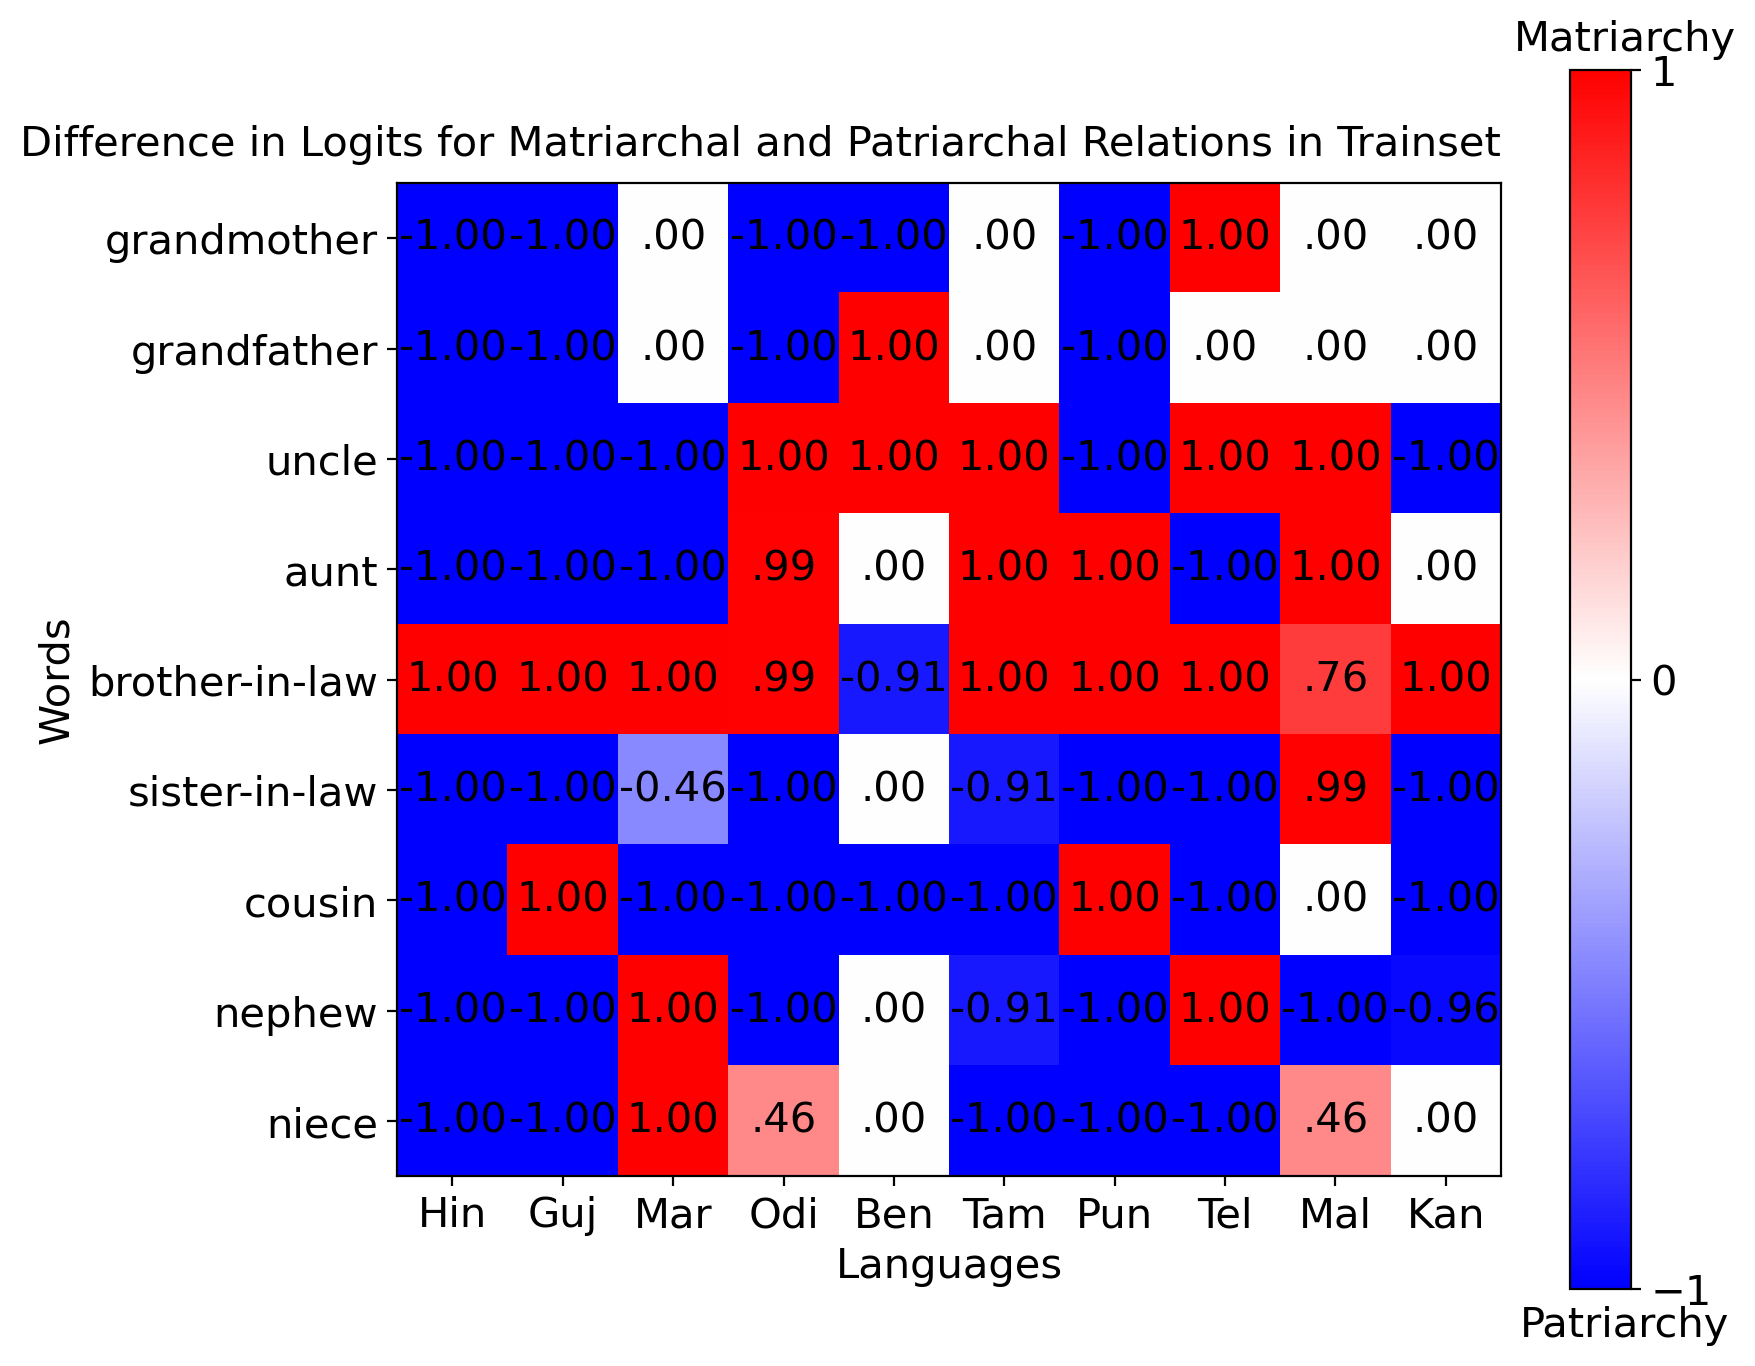

/tmp/ipykernel_635512/1652602798.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ambiguos_words, fontsize=15)


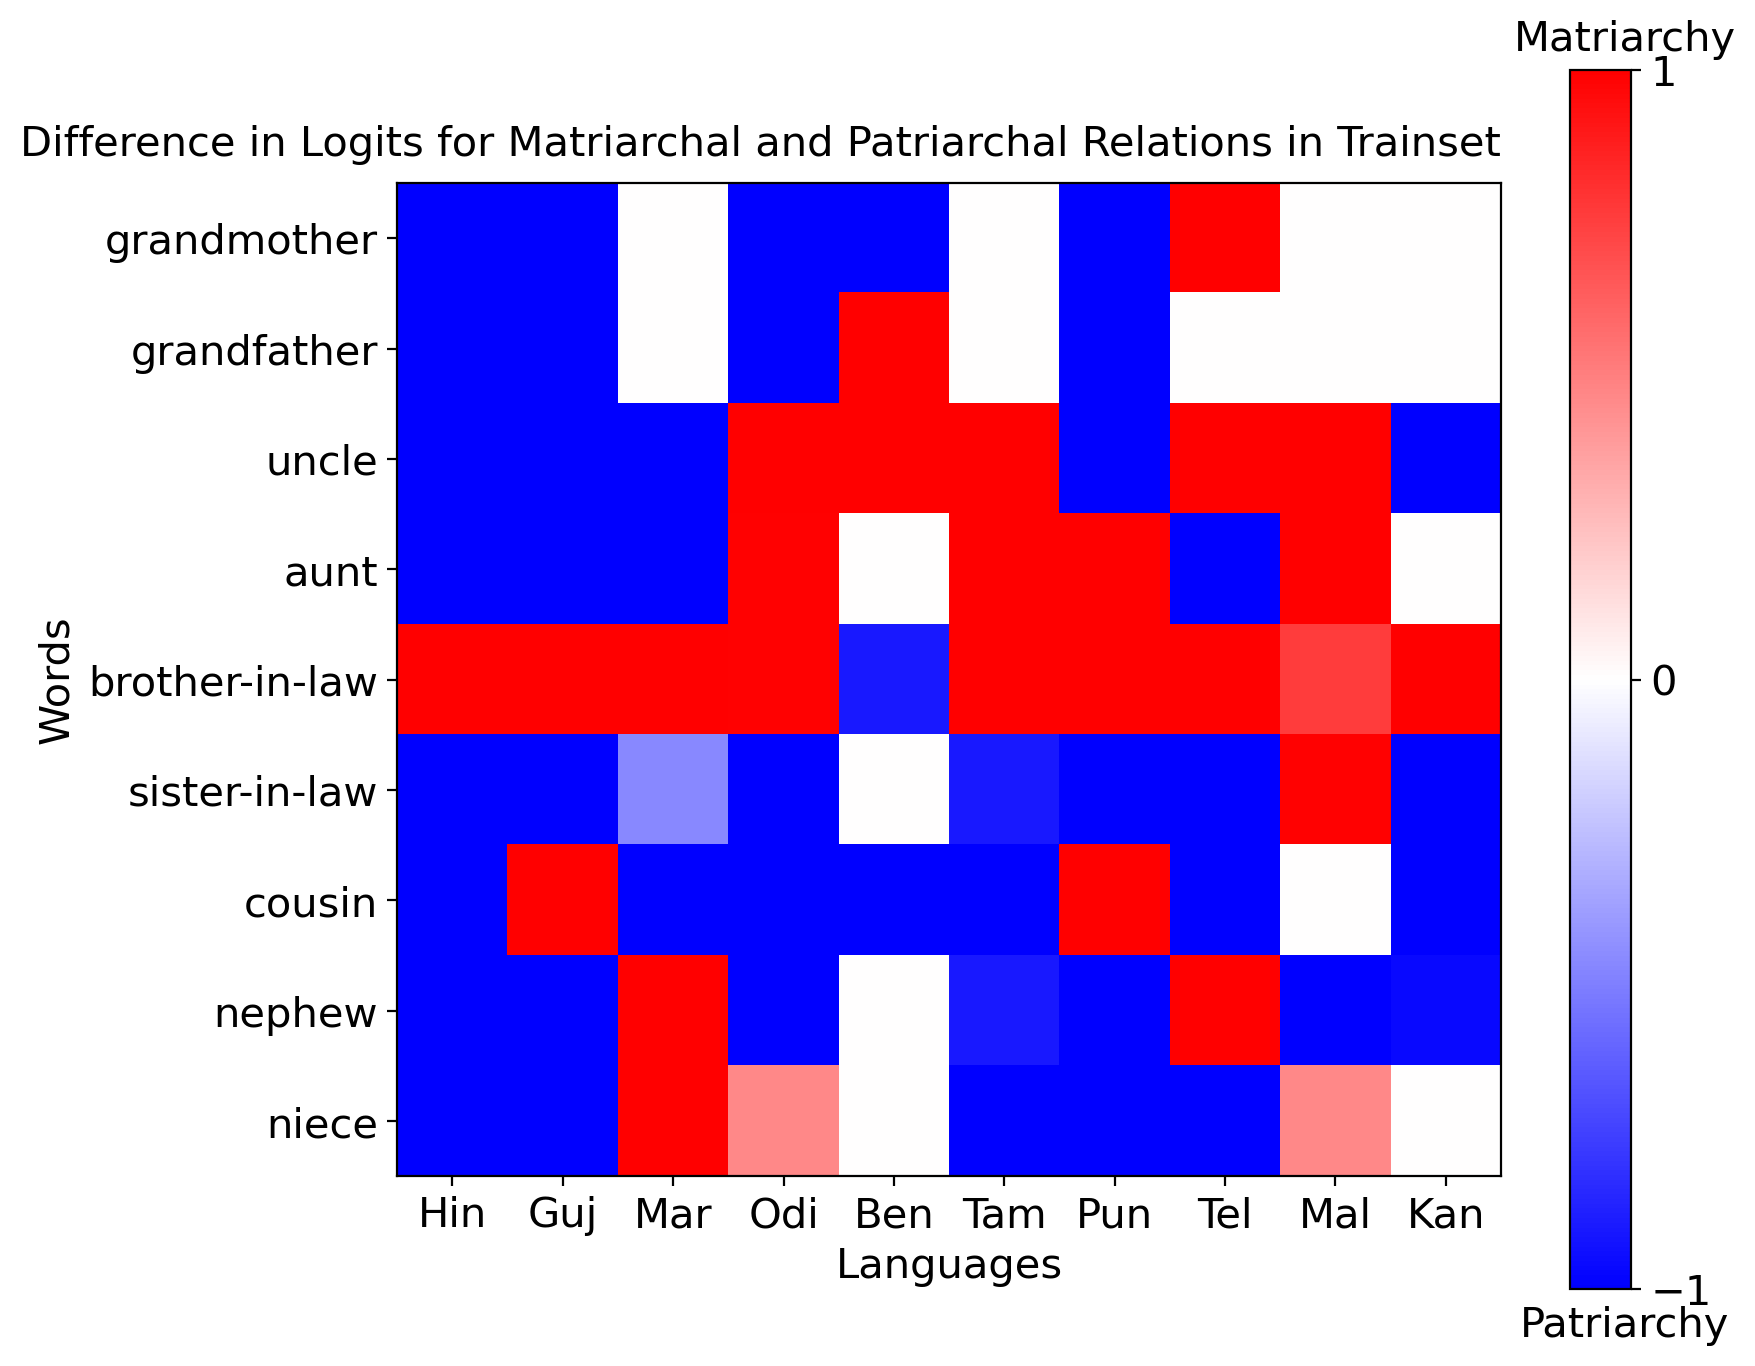

In [50]:

plot_confusion_mat(train_diff_confusion_mat,  ambiguos_words, lang_code_map, annot=True, filename='trainset_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Logits for Matriarchal and Patriarchal Relations in Trainset')
plot_confusion_mat(train_diff_confusion_mat,  ambiguos_words, lang_code_map, annot=False, filename='trainset_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Logits for Matriarchal and Patriarchal Relations in Trainset')
# plot_confusion_mat(train_ratio_conf_mat,  ambiguos_words, lang_code_map, annot=True, filename='trainset_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Trainset')
# plot_confusion_mat(train_ratio_conf_mat,  ambiguos_words, lang_code_map, annot=False, filename='trainset_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Trainset')